In [ ]:
# Adapted from https://keras.io/examples/vision/mnist_convnet/

In [257]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'family':'normal', 'weight':'normal','size':21})

# Create DataFrame for Benford's Law Distribution & define helper functions

In [174]:
# create dataframe with benford's law distribution
benford = pd.DataFrame.from_dict({
    '1': 30.1,
    '2': 17.6,
    '3': 12.5,
    '4': 9.7,
    '5': 7.9,
    '6': 6.7,
    '7': 5.8,
    '8': 5.1,
    '9': 4.6
}, orient= 'index')
benford.columns = ['benford']

In [175]:
def get_leading_digit(x):
    '''
    Remove negative sign and get first non-zero digit (ignoring decimal) - used with dataframe of weight values to get their leading digit
    '''
    x = str(abs(x))
    if x[0] == '0':
        return str(int(x.split(".")[1]))[0]
    else:
        return x.split(".")[0]

In [304]:
def plot_benford_for_first_layer(title, save_file = None):
    
    # convert weights to dataframe
    leading_digits = pd.DataFrame(model.layers[0].get_weights()[0].flatten())
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)
    
    # plot
    if not save_file:
        print(df)
        print()
        print(f">>> Mean absolute deviation: {mad}")
    df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")
    
    # save plot
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')

In [313]:
def plot_benford_for_all_layers(title, save_file = None):
    # gather all weights in the model
    weights = []
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            weights.extend(layer.get_weights()[0].flatten())

    # convert weights to dataframe
    leading_digits = pd.DataFrame(weights)
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)

    # plot
    if not save_file:
        print(df)
        print()
        print(f">>> Mean absolute deviation: {round(df['abs_deviation'].mean(),2)}")
    df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")
    
    # save plot
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')

In [314]:
# Keras callback to plot leading digit distribution after each epoch
class PlotBenford(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        plot_benford_for_first_layer("BEFORE TRAINING: 1st layer weights leading digit distribution vs. Benford's Law", 'plots/before_layer1.jpg')
        plot_benford_for_all_layers("BEFORE TRAINING: All layers' weights leading digit distribution vs. Benford's Law", 'plots/before_layers.jpg')
        
    def on_train_end(self, logs={}):
        plot_benford_for_first_layer("AFTER TRAINING: 1st layer weights leading digit distribution vs. Benford's Law", 'plots/after_layer1.jpg')
        plot_benford_for_all_layers("AFTER TRAINING: All layers' weights leading digit distribution vs. Benford's Law", 'plots/after_layers.jpg')

    def on_epoch_end(self, batch, logs={}):
        self.epoch+=1
        plot_benford_for_all_layers(f"All layers weight leading digit distribution vs Benford's Law: Epoch {self.epoch}", f'gif/epoch_{self.epoch:02}.jpg')

# Train CNN on MNIST 

In [315]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [316]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)              

In [317]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [323]:
benford_callback = PlotBenford()
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1, callbacks = [benford_callback])

In [319]:
model.save("trained_model.h5")
# model = tf.keras.models.load_model("trained_model.h5")

In [320]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02545891131706594
Test accuracy: 0.9918


# Plot weight leading digit distribution vs. Benford's Law

## First layer only

   benford  leading_digit  deviation
1     30.1       9.722222 -20.377778
2     17.6      12.673611  -4.926389
3     12.5       9.722222  -2.777778
4      9.7      11.805556   2.105556
5      7.9      10.243056   2.343056
6      6.7      13.020833   6.320833
7      5.8       9.027778   3.227778
8      5.1      11.805556   6.705556
9      4.6      11.979167   7.379167

>>> Mean absolute deviation: 6.24


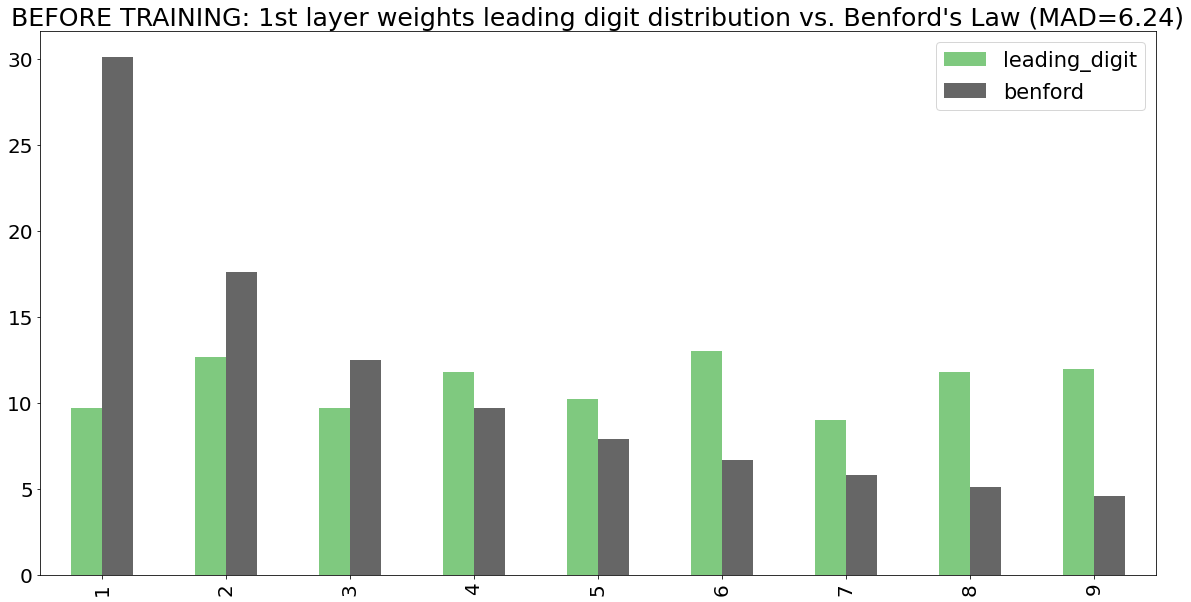

In [300]:
plot_benford_for_first_layer("BEFORE TRAINING: 1st layer weights leading digit distribution vs. Benford's Law")

   benford  leading_digit  deviation  abs_deviation
1     30.1      34.201389   4.101389       4.101389
2     17.6      24.305556   6.705556       6.705556
3     12.5      13.020833   0.520833       0.520833
4      9.7       4.861111  -4.838889       4.838889
5      7.9       4.513889  -3.386111       3.386111
6      6.7       5.034722  -1.665278       1.665278
7      5.8       5.034722  -0.765278       0.765278
8      5.1       6.076389   0.976389       0.976389
9      4.6       2.951389  -1.648611       1.648611

>>> Mean absolute deviation: 2.73


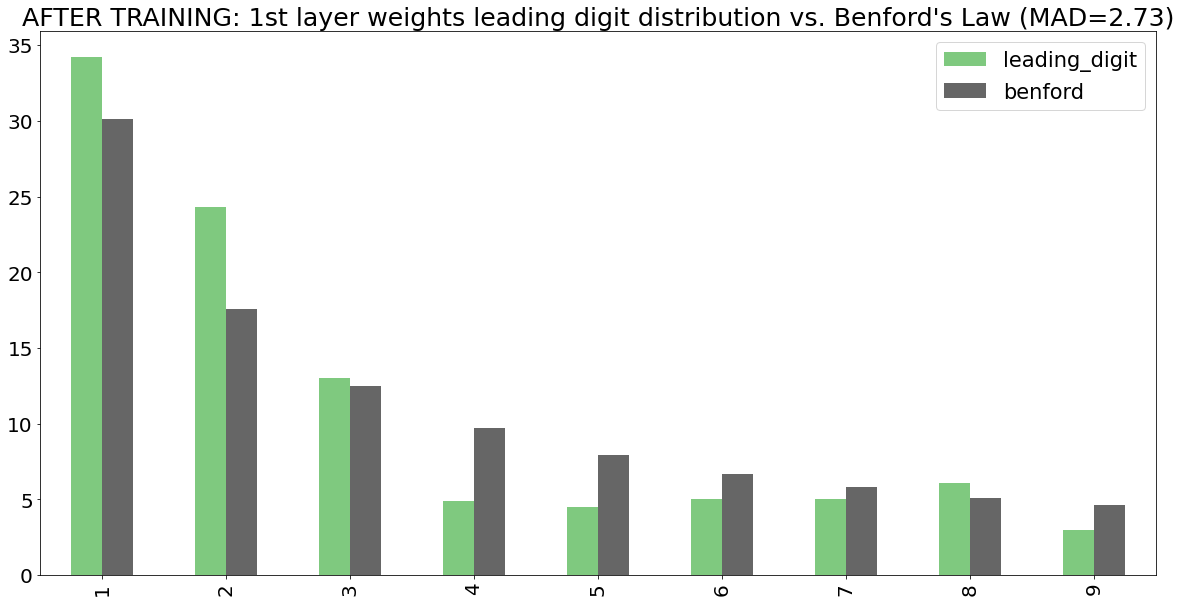

In [321]:
plot_benford_for_first_layer("AFTER TRAINING: 1st layer weights leading digit distribution vs. Benford's Law")

## All layers

   benford  leading_digit  deviation
1     30.1      15.965569 -14.134431
2     17.6      16.059132  -1.540868
3     12.5      16.420284   3.920284
4      9.7      16.358533   6.658533
5      7.9      16.126497   8.226497
6      6.7      11.918039   5.218039
7      5.8       3.714446  -2.085554
8      5.1       1.657934  -3.442066
9      4.6       1.779566  -2.820434

>>> Mean absolute deviation: 5.34


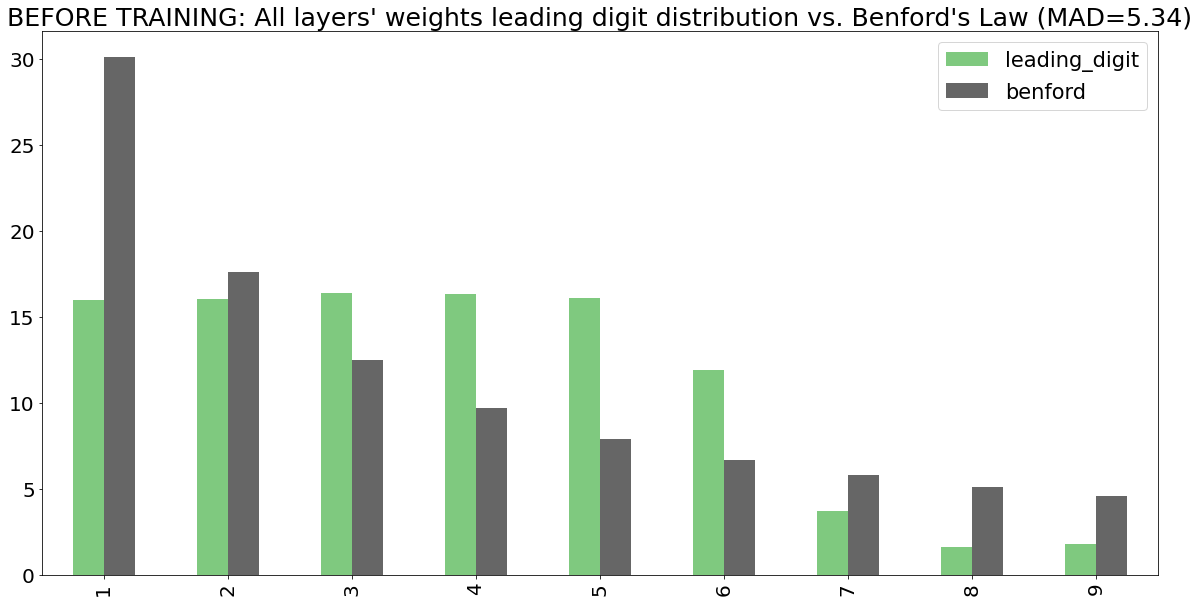

In [301]:
plot_benford_for_all_layers("BEFORE TRAINING: All layers' weights leading digit distribution vs. Benford's Law")

   benford  leading_digit  deviation  abs_deviation
1     30.1      33.562874   3.462874       3.462874
2     17.6      14.339446  -3.260554       3.260554
3     12.5      10.014970  -2.485030       2.485030
4      9.7       8.357036  -1.342964       1.342964
5      7.9       7.945359   0.045359       0.045359
6      6.7       7.107036   0.407036       0.407036
7      5.8       6.816991   1.016991       1.016991
8      5.1       6.105913   1.005913       1.005913
9      4.6       5.750374   1.150374       1.150374

>>> Mean absolute deviation: 1.58


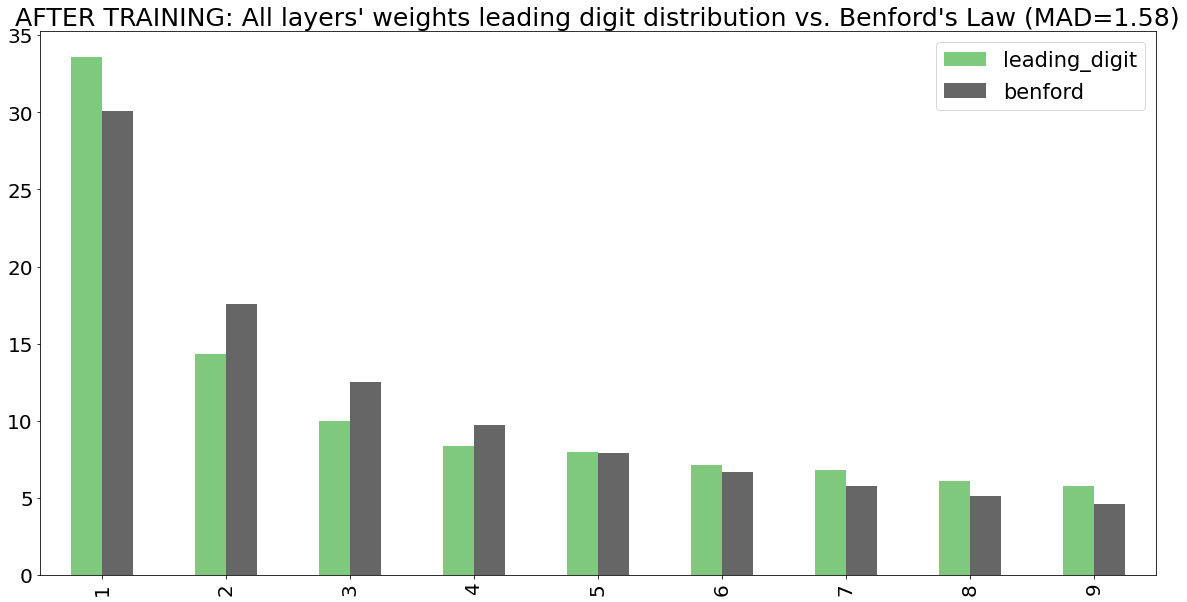

In [322]:
plot_benford_for_all_layers("AFTER TRAINING: All layers' weights leading digit distribution vs. Benford's Law")